In [ ]:
!time pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.1 MB/s eta 0:00:00

real	0m17.455s
user	0m8.333s
sys	0m0.896s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
# import scipy as sp

import random
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

#Dual active models

In [ ]:
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

0    8975
1     916
Name: Target, dtype: int64

In [ ]:
dchm= sxl["Smiles"]
mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(mols)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]
df

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

# Hyperparameter Tuning

---

Random Forest Hyperparameters we’ll be Looking at:

*   Number of trees (n_estimators)
*   Number of Samples (subsample)
*   Number of Features (max_features)
*   Learning Rate
*   Tree Depth (max_depth)
---
https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

>10 0.943 (0.003)
>50 0.960 (0.005)
>100 0.965 (0.005)
>500 0.977 (0.004)
>1000 0.979 (0.004)
>5000 0.978 (0.005)


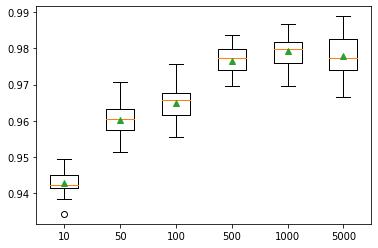

In [ ]:

# explore gradient boosting number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.1 0.940 (0.025)
>1.1 nan (nan)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 317, in _check_params
    raise ValueError("subsample must be in (0,1] but was %r" % self.subsample)
ValueError: subsample mu

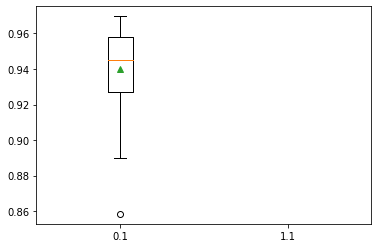

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in (0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1,21):
		models[str(i)] = GradientBoostingClassifier(max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.963 (0.019)
>2 0.935 (0.094)
>3 0.953 (0.047)
>4 0.916 (0.098)
>5 0.898 (0.109)


KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# define learning rates to explore
	for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i, max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,11):
		models[str(i)] = GradientBoostingClassifier(max_depth=i, learning_rate=i, max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X = Xt_train
y = Yt_train
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [ 500]
grid['learning_rate'] = [ 0.001, 0.01, 0.1]
grid['subsample'] = [0.1]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.960439 (0.005620) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.969413 (0.005733) with: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.969877 (0.005482) with: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.959385 (0.014274) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.693676 (0.179044) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.674639 (0.170951) with: {'learning_rate': 0.1, 'max_depth

#Training

In [ ]:
# load library
from sklearn.ensemble import GradientBoostingClassifier
# Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
xgbc = GradientBoostingClassifier( learning_rate=0.01, subsample=0.1, n_estimators=500, max_depth= 9)

# fit the predictor and target
xgbc.fit(Xt_train, Yt_train)


In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'sexualsGBM_HPTFInal_UMACCS_model.pkl'
joblib.dump(xgbc, filename)

#Load sexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("sexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,S_Hit,Smiles
0,25658,<rdkit.Chem.rdchem.Mol object at 0x7fc9363b4c10>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,39559,<rdkit.Chem.rdchem.Mol object at 0x7fc9362189e0>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,36544,<rdkit.Chem.rdchem.Mol object at 0x7fc936195770>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,58789,<rdkit.Chem.rdchem.Mol object at 0x7fc935d5bd80>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,15213,<rdkit.Chem.rdchem.Mol object at 0x7fc9365e8190>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...,...
62370,50615,<rdkit.Chem.rdchem.Mol object at 0x7fc935ffa1f0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,57063,<rdkit.Chem.rdchem.Mol object at 0x7fc935f145f0>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,19513,<rdkit.Chem.rdchem.Mol object at 0x7fc9364a6ff0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,41985,<rdkit.Chem.rdchem.Mol object at 0x7fc93607fa00>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'S_Hit', "Smiles"])
sxl=dff
sxl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c9e0>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,<rdkit.Chem.rdchem.Mol object at 0x7f71c322d000>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c580>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c740>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c7b0>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...
62370,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d49e0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4a50>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4ac0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4b30>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

dpchm= sxl
dpchm
dpchm["Target"] = np.where(dpchm["S_Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)

df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62370,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,1,1,0
62371,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
62372,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
62373,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
Xt_test = df
Yt_test= sxl["Target"]

#GBM

In [ ]:

gbm_model = joblib.load('sexualsGBM_HPTFInal_UMACCS_model.pkl')

In [ ]:
xgbc_predict = gbm_model.predict(Xt_test)
p= xgbc_predict
p= pd.DataFrame(p)
print(p.value_counts())


0    61896
1      479
dtype: int64


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,xgbc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,xgbc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,xgbc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,xgbc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,xgbc_predict)
cm

Accuracy: 0.992818
Recall 0.632479
precision 0.154489
F1 score: 0.248322


array([[61853,   405],
       [   43,    74]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, xgbc_predict))
print('Accuracy score:',accuracy_score(Yt_test, xgbc_predict))
print('F1 score:',f1_score(Yt_test,xgbc_predict))

ROCAUC score: 0.8129867221951773
Accuracy score: 0.9928176352705411
F1 score: 0.24832214765100669


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, xgbc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, xgbc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, xgbc_predict)
print(matrix)

Cohens kappa: 0.246049
ROC AUC: 0.812987
[[61853   405]
 [   43    74]]


#Asexual models

In [ ]:
import pandas as pd
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

len(compounds)

59530

In [ ]:
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

1    30393
0    29143
Name: Target, dtype: int64

In [ ]:
compounds
dpchm= pd.DataFrame (compounds, columns = ['mol', 'hit'])
dpchm["Target"] = np.where(dpchm["hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
dchm

0        <rdkit.Chem.rdchem.Mol object at 0x7f695b8060b0>
1        <rdkit.Chem.rdchem.Mol object at 0x7f695b806120>
2        <rdkit.Chem.rdchem.Mol object at 0x7f695b806190>
3        <rdkit.Chem.rdchem.Mol object at 0x7f695b806200>
4        <rdkit.Chem.rdchem.Mol object at 0x7f695b806270>
                               ...                       
59525    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81dd0>
59526    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81e40>
59527    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81eb0>
59528    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81f20>
59529    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81f90>
Name: mol, Length: 59530, dtype: object

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
dpchm['hit']= np.where(dpchm['hit']== "Yes", 1,0)

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, dpchm['hit'],test_size=0.2, random_state=42)

# Hyperparameter Tuning

---

Random Forest Hyperparameters we’ll be Looking at:

*   Number of trees (n_estimators)
*   Number of Samples (subsample)
*   Number of Features (max_features)
*   Learning Rate
*   Tree Depth (max_depth)
---
https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

In [ ]:

# evaluate gradient boosting algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:

# explore gradient boosting number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models


 # define dataset
X = Xt_train
y = Yt_train

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.840 (0.005)
>50 0.891 (0.005)
>100 0.908 (0.004)
>500 0.933 (0.004)


KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in (0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=500)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

 # define dataset
X = Xt_train
y = Yt_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1,21):
		models[str(i)] = GradientBoostingClassifier(max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

 # define dataset
X = Xt_train
y = Yt_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.963 (0.019)
>2 0.935 (0.094)
>3 0.953 (0.047)
>4 0.916 (0.098)
>5 0.898 (0.109)


KeyboardInterrupt: ignored

In [ ]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X = Xt_train
y = Yt_train
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [ 500]
grid['learning_rate'] = [ 0.01, 0.1]
grid['subsample'] = [0.1]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.935999 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.892449 (0.002100) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.925899 (0.001743) with: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.935999 (0.002730) with: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.922665 (0.001785) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.859357 (0.015328) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.699836 (0.037649) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}


# Training

In [ ]:
# load library
from sklearn.ensemble import GradientBoostingClassifier
# Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
xgbc = GradientBoostingClassifier( learning_rate=0.01, subsample=0.1, n_estimators=500, max_depth= 9)

# fit the predictor and target
xgbc.fit(Xt_train, Yt_train)

In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'asexualsGBM_HPTFInal_UMACCS_model.pkl'
joblib.dump(xgbc, filename)

#Load Asexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("asexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,Hit,Smiles
0,51742,<rdkit.Chem.rdchem.Mol object at 0x7f71149bf680>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,20279,<rdkit.Chem.rdchem.Mol object at 0x7f7114ed6180>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,17729,<rdkit.Chem.rdchem.Mol object at 0x7f71219e38b0>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,28545,<rdkit.Chem.rdchem.Mol object at 0x7f7114dc26c0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,24371,<rdkit.Chem.rdchem.Mol object at 0x7f7114f4b140>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...,...
61024,72080,<rdkit.Chem.rdchem.Mol object at 0x7f7114740cf0>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,49244,<rdkit.Chem.rdchem.Mol object at 0x7f7114b4a340>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,47413,<rdkit.Chem.rdchem.Mol object at 0x7f7114afbae0>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,73164,<rdkit.Chem.rdchem.Mol object at 0x7f711476eb20>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl=dff
axl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f7113906500>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,<rdkit.Chem.rdchem.Mol object at 0x7f7113906960>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,<rdkit.Chem.rdchem.Mol object at 0x7f7113907680>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,<rdkit.Chem.rdchem.Mol object at 0x7f71139061f0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,<rdkit.Chem.rdchem.Mol object at 0x7f7113906c00>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...
61024,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2ef80>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2eff0>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f060>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f0d0>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
axl["Hit"].value_counts()

No     58241
Yes     2788
Name: Hit, dtype: int64

##MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dpchm= axl
#dchm
dpchm["Target"] = np.where(dpchm["Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]

df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61024,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
61025,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
61026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
61027,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


In [ ]:
Xt_test = df
Yt_test= axl["Target"]

#GBM

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib


In [ ]:

gbm_model = joblib.load('asexualsGBM_HPTFInal_UMACCS_model.pkl')

In [ ]:
xgbc_predict = gbm_model.predict(Xt_test)
p= xgbc_predict
p= pd.DataFrame(p)
print(p.value_counts())


No     48897
Yes    12132
dtype: int64


In [ ]:
xgbc_predict

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [ ]:
Yt_test

49688    0
44298    0
52891    0
24374    0
20956    0
        ..
53567    0
68400    0
23311    0
27686    0
46948    0
Name: Target, Length: 61029, dtype: int64

In [ ]:
xgbc_predict= np.where(xgbc_predict== "Yes", 1,0)
#Yt_test= np.where(Yt_test== "Yes", 1,0)

In [ ]:
xgbc_predict
#Yt_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,xgbc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,xgbc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,xgbc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,xgbc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,xgbc_predict)
cm

Accuracy: 0.837422
Recall 0.896341
precision 0.205984
F1 score: 0.334987


array([[48608,  9633],
       [  289,  2499]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, xgbc_predict))
print('Accuracy score:',accuracy_score(Yt_test, xgbc_predict))
print('F1 score:',f1_score(Yt_test,xgbc_predict))

ROCAUC score: 0.8654712588273871
Accuracy score: 0.8374215536875912
F1 score: 0.33498659517426277


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, xgbc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, xgbc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, xgbc_predict)
print(matrix)

Cohens kappa: 0.281615
ROC AUC: 0.865471
[[48608  9633]
 [  289  2499]]
